<a href="https://colab.research.google.com/github/JasonLimJS/EURUSD_Forecast/blob/master/2_Training_Deep_Learning_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction:**

This document details all the steps involved in training a neural network ensemble. After some hyperparameter tuning, it has been observed that EUR/USD exchange rate could be most accurately being predicted with an ensemble of 10 neural networks where each neural network contains 2  hidden layers that come with sigmoid activation function whereas the output layer is activated via linear function. 


EUR/USD exchange rate would be most accurately predicted with only USD 3M LIBOR and EUR 3M LIBOR as inputs. The reasons for that might be due to the usage of these 2 rates in a lot of derivatives fixing.

**Model performance:**

RMSE: 0.13987 (Around 88 pips difference with the actual exchange rate on average)


1. Creating normalized daily returns of EURUSD, and select only features of USD 3M LIBOR and EUR 3M LIBOR.

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import backend as K
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE
from scipy.stats import norm
from tensorflow.math import erf
import warnings
import matplotlib.pyplot as plt

warnings.simplefilter('ignore')
drive.mount('drive')

raw_data= pd.read_csv('drive/My Drive/Trading EURUSD with Deep Learning Algorithms/input_data.csv')
raw_data['EURUSD_lead']= raw_data['EURUSD'].shift(-1)
raw_data['EURUSD_return']= (raw_data.EURUSD_lead/raw_data.EURUSD-1)*100
mean_return= np.mean(raw_data['EURUSD_return'])
sd_return= np.var(raw_data['EURUSD_return'])**0.5
raw_data['EURUSD_return']= (raw_data['EURUSD_return']- np.mean(raw_data['EURUSD_return']))/np.var(raw_data['EURUSD_return'])**0.5
raw_data.dropna(inplace=True)



raw_data.drop(['EURUSD','EURUSD_lead','vix','bond_spread','ice_swap_2y','ice_swap_3y','ice_swap_5y','ice_swap_7y','snp500','usd_libor_1m','eur_libor_1m'],axis=1,inplace=True)


print(raw_data.info())
print(raw_data.head(5))
print('Mean Return of EURUSD: ' + str(mean_return))
print('Standard Deviation of Return of EURUSD: ' + str(sd_return))

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
Int64Index: 239 entries, 0 to 238
Data columns (total 3 columns):
usd_libor_3m     239 non-null float64
eur_libor_3m     239 non-null float64
EURUSD_return    239 non-null float64
dtypes: float64(3)
memory usage: 7.5 KB
None
   usd_libor_3m  eur_libor_3m  EURUSD_return
0       2.34750      -0.35771       1.400090
1       2.34706      -0.35771       1.231940
2       2.34156      -0.35557      -0.883293
3       2.33531      -0.35614      -1.783914
4       2.33488      -0.35643      -0.637832
Mean Return of EURUSD: -0.012656776718944591
Standard Deviation of Return of EURUSD: 0.37153574053203325


2. Exploratory Data Analysis

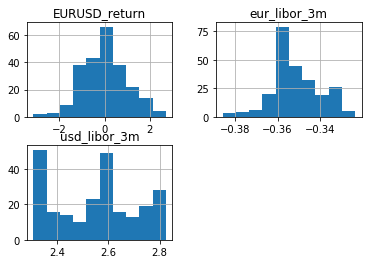

In [0]:
raw_data.hist()

target= raw_data['EURUSD_return'].values
predictors= raw_data.drop(['EURUSD_return'],axis=1).values


3. Initialize Function to Train Deep Learning Model (2 Hidden Layers with Sigmoid Activation Functions)

In [0]:
act_layer1_ls=[]
input_col_ls=[]
neurons_layer1_ls=[]
ind_layer2_ls=[]
act_layer2_ls=[]
neurons_layer2_ls=[]
ind_output_ls=[]
act_output_ls=[]
lr_ls=[]
bs_ls=[]
ep_ls=[]
RMSE_ls=[]
uniq_count_ls=[]
#RMSE_min= np.Inf
#best_model=None
n_cols= predictors.shape[1]

def custom_tanh(x):
  return 10*K.tanh(x)

def custom_Gaussian(x):
  return K.exp(-K.pow(x,2))

def custom_soft_clip(x,alpha=1):
  return (1/alpha)*K.log((1+K.exp(x*alpha))/(1+K.exp(x*alpha-1)))

def ANN_training(act_layer1='relu',input_col=n_cols,neurons_layer1=25,ind_layer2=False,act_layer2=None,neurons_layer2=None,ind_output=False,act_output=None,
                 lr=0.0001,bs=10,ep=250,RMSE_min=RMSE_min,best_model=best_model,stop_step=300):
  
  model= Sequential()
  
  #Input layer to Hidden Layer 1
  model.add(Dense(neurons_layer1,activation=act_layer1,input_shape=(input_col,)))
  
  if ind_layer2==True:
    #Hidden Layer 1 to Hidden Layer 2
    model.add(Dense(neurons_layer2,activation=act_layer2))
    
  if ind_output==True:
    #Hidden Layer 2 to Output Layer
    model.add(Dense(1,activation=act_output))  
  else:
    model.add(Dense(1))

  adam= Adam(lr=lr)
  model.compile(optimizer=adam, loss='mean_squared_error')
  
  train_index_end= int(len(predictors)*0.8)
  test_index_end= len(predictors)
  
  X_train_pre= predictors[0:train_index_end]
  X_test_pre= predictors[train_index_end:test_index_end]
  y_train_pre= target[0:train_index_end]
  y_test_pre= target[train_index_end:test_index_end]
  
  X_norm= MinMaxScaler()
  Y_norm= MinMaxScaler()
  
  X_train= X_norm.fit_transform(X_train_pre)
  X_test= X_norm.transform(X_test_pre)
  y_train= Y_norm.fit_transform(y_train_pre.reshape(-1,1))
  y_test= Y_norm.transform(y_test_pre.reshape(-1,1))
  
  early_stopping_monitor= EarlyStopping(patience=stop_step)
  
  model.fit(X_train,y_train,epochs=ep,verbose=True,validation_split=0.4,batch_size=bs,callbacks=[early_stopping_monitor])
  
  y_pred= model.predict(X_test)
  RMSE= MSE(y_test,y_pred)**0.5
  uniq_count= len(np.unique(y_pred))
  
  RMSE_ls.append(RMSE)
  uniq_count_ls.append(uniq_count)
  
  #if RMSE < RMSE_min:
    #best_model= model
    #RMSE_min=RMSE
  #else:
    #best_model= best_model
    #RMSE_min= RMSE_min
    
    
  return model, RMSE

4. Training 10 Deep Learning Models (2 Hidden Layers with Sigmoid Activation Functions)




In [0]:
input_col= n_cols
ind_layer2= False
act_layer2= None
neurons_layer2= None
ind_output= False
act_output= None

        
op_ind= 0
stop_step= 10

for i in range(1,11):
  for act_layer1 in ['sigmoid']:
    for neurons_layer1 in [25]:
      for lr in [0.001]:
       for bs in [100]:
          for ep in [300]:


            act_layer1_ls.append(act_layer1)
            input_col_ls.append(input_col)
            neurons_layer1_ls.append(neurons_layer1)
            ind_layer2_ls.append(ind_layer2)
            act_layer2_ls.append(act_layer2)
            neurons_layer2_ls.append(neurons_layer2)
            ind_output_ls.append(ind_output)
            act_output_ls.append(act_output)
            lr_ls.append(lr)
            bs_ls.append(bs)
            ep_ls.append(ep)

            locals() ['model_train_' + str(i)], RMSE=ANN_training(act_layer1= act_layer1,
                                                      input_col= input_col,
                                                      neurons_layer1= neurons_layer1,
                                                      ind_layer2= ind_layer2,
                                                      act_layer2= act_layer2,
                                                      neurons_layer2= neurons_layer2,
                                                      ind_output= ind_output,
                                                      act_output= act_output,
                                                      lr= lr,
                                                      bs= bs,
                                                      ep= ep,
                                                      RMSE_min= RMSE_min,
                                                      best_model=best_model,
                                                      stop_step= stop_step)
            op_ind += 1

            print("Operation " + str(op_ind) + " completed!")
            print('RMSE of the trained model ' + str(i) + ' is: ' + str(RMSE))

       


Train on 114 samples, validate on 77 samples
Epoch 1/300
114/114 [==============================] - 0s 1ms/step - loss: 0.4135 - val_loss: 0.3415
Epoch 2/300
114/114 [==============================] - 0s 88us/step - loss: 0.3762 - val_loss: 0.3055
Epoch 3/300
114/114 [==============================] - 0s 81us/step - loss: 0.3414 - val_loss: 0.2720
Epoch 4/300
114/114 [==============================] - 0s 79us/step - loss: 0.3086 - val_loss: 0.2409
Epoch 5/300
114/114 [==============================] - 0s 89us/step - loss: 0.2779 - val_loss: 0.2122
Epoch 6/300
114/114 [==============================] - 0s 76us/step - loss: 0.2494 - val_loss: 0.1859
Epoch 7/300
114/114 [==============================] - 0s 78us/step - loss: 0.2230 - val_loss: 0.1619
Epoch 8/300
114/114 [==============================] - 0s 77us/step - loss: 0.1985 - val_loss: 0.1399
Epoch 9/300
114/114 [==============================] - 0s 79us/step - loss: 0.1767 - val_loss: 0.1202
Epoch 10/300
114/114 [================

5. Validating the invidual trained models using test data.

model_train_1


y_pred: [0.49909472]|y_test: [0.82453399]
y_pred: [0.50569075]|y_test: [0.51924743]
y_pred: [0.5117471]|y_test: [0.30989464]
y_pred: [0.49657482]|y_test: [0.72539204]
y_pred: [0.4980001]|y_test: [0.48632996]
y_pred: [0.5476536]|y_test: [0.61381076]
y_pred: [0.5317451]|y_test: [0.50688718]
y_pred: [0.49038577]|y_test: [0.69599409]
y_pred: [0.470554]|y_test: [0.60533423]
y_pred: [0.49529243]|y_test: [0.46610205]
y_pred: [0.482821]|y_test: [0.36758053]
y_pred: [0.51623267]|y_test: [0.6261693]
y_pred: [0.51636463]|y_test: [0.41651457]
y_pred: [0.5224672]|y_test: [0.52326547]
y_pred: [0.5360296]|y_test: [0.51913501]
y_pred: [0.55682164]|y_test: [0.58509699]
y_pred: [0.5386604]|y_test: [0.41203001]
y_pred: [0.557786]|y_test: [0.74217919]
y_pred: [0.5614118]|y_test: [0.58911503]
y_pred: [0.51776975]|y_test: [0.51920347]
y_pred: [0.5195398]|y_test: [0.39582924]
y_pred: [0.5402525]|y_test: [0.45310578]
y_pred: [0.53753567]|y_test: [0.61413117]
y_pred: [0.53729564]|y_test: [0.684

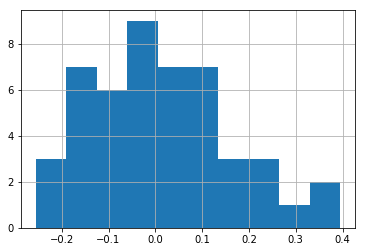

model_train_2


y_pred: [0.5369168]|y_test: [0.82453399]
y_pred: [0.5317444]|y_test: [0.51924743]
y_pred: [0.5280821]|y_test: [0.30989464]
y_pred: [0.5377429]|y_test: [0.72539204]
y_pred: [0.5364035]|y_test: [0.48632996]
y_pred: [0.5072233]|y_test: [0.61381076]
y_pred: [0.51615816]|y_test: [0.50688718]
y_pred: [0.5399929]|y_test: [0.69599409]
y_pred: [0.55150306]|y_test: [0.60533423]
y_pred: [0.535797]|y_test: [0.46610205]
y_pred: [0.5423902]|y_test: [0.36758053]
y_pred: [0.5231457]|y_test: [0.6261693]
y_pred: [0.5209335]|y_test: [0.41651457]
y_pred: [0.51610136]|y_test: [0.52326547]
y_pred: [0.50719464]|y_test: [0.51913501]
y_pred: [0.49367476]|y_test: [0.58509699]
y_pred: [0.50521773]|y_test: [0.41203001]
y_pred: [0.49400207]|y_test: [0.74217919]
y_pred: [0.49116293]|y_test: [0.58911503]
y_pred: [0.51715887]|y_test: [0.51920347]
y_pred: [0.51631236]|y_test: [0.39582924]
y_pred: [0.50415295]|y_test: [0.45310578]
y_pred: [0.5059118]|y_test: [0.61413117]
y_pred: [0.505532]|y_test: [0.68

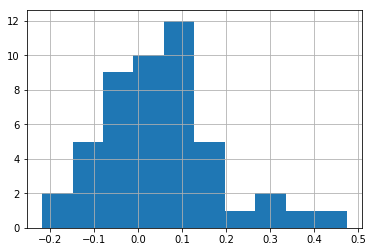

model_train_3


y_pred: [0.5735657]|y_test: [0.82453399]
y_pred: [0.5702174]|y_test: [0.51924743]
y_pred: [0.5687042]|y_test: [0.30989464]
y_pred: [0.5731971]|y_test: [0.72539204]
y_pred: [0.57215583]|y_test: [0.48632996]
y_pred: [0.56104124]|y_test: [0.61381076]
y_pred: [0.5639752]|y_test: [0.50688718]
y_pred: [0.57261974]|y_test: [0.69599409]
y_pred: [0.57695925]|y_test: [0.60533423]
y_pred: [0.56962675]|y_test: [0.46610205]
y_pred: [0.5714356]|y_test: [0.36758053]
y_pred: [0.5643789]|y_test: [0.6261693]
y_pred: [0.56127435]|y_test: [0.41651457]
y_pred: [0.55809456]|y_test: [0.52326547]
y_pred: [0.5536724]|y_test: [0.51913501]
y_pred: [0.54710907]|y_test: [0.58509699]
y_pred: [0.5524548]|y_test: [0.41203001]
y_pred: [0.5481944]|y_test: [0.74217919]
y_pred: [0.5463524]|y_test: [0.58911503]
y_pred: [0.55671096]|y_test: [0.51920347]
y_pred: [0.5565858]|y_test: [0.39582924]
y_pred: [0.5519088]|y_test: [0.45310578]
y_pred: [0.5527567]|y_test: [0.61413117]
y_pred: [0.55205685]|y_test: [0.6

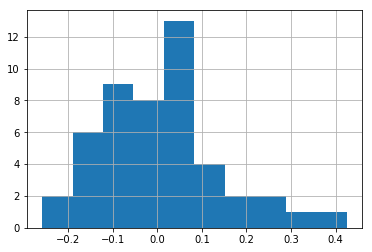

model_train_4


y_pred: [0.5670165]|y_test: [0.82453399]
y_pred: [0.5661643]|y_test: [0.51924743]
y_pred: [0.5679891]|y_test: [0.30989464]
y_pred: [0.56459296]|y_test: [0.72539204]
y_pred: [0.5638778]|y_test: [0.48632996]
y_pred: [0.58101624]|y_test: [0.61381076]
y_pred: [0.5744715]|y_test: [0.50688718]
y_pred: [0.55918616]|y_test: [0.69599409]
y_pred: [0.5522017]|y_test: [0.60533423]
y_pred: [0.5577128]|y_test: [0.46610205]
y_pred: [0.55177426]|y_test: [0.36758053]
y_pred: [0.5640035]|y_test: [0.6261693]
y_pred: [0.5589278]|y_test: [0.41651457]
y_pred: [0.55802035]|y_test: [0.52326547]
y_pred: [0.56041443]|y_test: [0.51913501]
y_pred: [0.5644599]|y_test: [0.58509699]
y_pred: [0.56028175]|y_test: [0.41203001]
y_pred: [0.56695616]|y_test: [0.74217919]
y_pred: [0.5665048]|y_test: [0.58911503]
y_pred: [0.5523399]|y_test: [0.51920347]
y_pred: [0.55340445]|y_test: [0.39582924]
y_pred: [0.56051904]|y_test: [0.45310578]
y_pred: [0.5599749]|y_test: [0.61413117]
y_pred: [0.55863875]|y_test: [0.

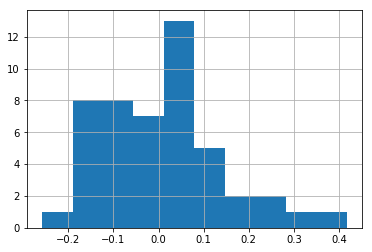

model_train_5


y_pred: [0.5257034]|y_test: [0.82453399]
y_pred: [0.5167469]|y_test: [0.51924743]
y_pred: [0.51301384]|y_test: [0.30989464]
y_pred: [0.5243882]|y_test: [0.72539204]
y_pred: [0.52153915]|y_test: [0.48632996]
y_pred: [0.49470592]|y_test: [0.61381076]
y_pred: [0.5014739]|y_test: [0.50688718]
y_pred: [0.5221056]|y_test: [0.69599409]
y_pred: [0.5326034]|y_test: [0.60533423]
y_pred: [0.5139936]|y_test: [0.46610205]
y_pred: [0.517949]|y_test: [0.36758053]
y_pred: [0.5010177]|y_test: [0.6261693]
y_pred: [0.49208283]|y_test: [0.41651457]
y_pred: [0.48353913]|y_test: [0.52326547]
y_pred: [0.4721771]|y_test: [0.51913501]
y_pred: [0.4553839]|y_test: [0.58509699]
y_pred: [0.46893317]|y_test: [0.41203001]
y_pred: [0.45863017]|y_test: [0.74217919]
y_pred: [0.45368266]|y_test: [0.58911503]
y_pred: [0.47906524]|y_test: [0.51920347]
y_pred: [0.4788852]|y_test: [0.39582924]
y_pred: [0.4675216]|y_test: [0.45310578]
y_pred: [0.46968818]|y_test: [0.61413117]
y_pred: [0.46764028]|y_test: [0.6

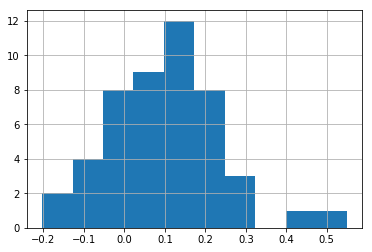

model_train_6


y_pred: [0.5535435]|y_test: [0.82453399]
y_pred: [0.54539484]|y_test: [0.51924743]
y_pred: [0.5376687]|y_test: [0.30989464]
y_pred: [0.55691314]|y_test: [0.72539204]
y_pred: [0.5552025]|y_test: [0.48632996]
y_pred: [0.49166074]|y_test: [0.61381076]
y_pred: [0.5121126]|y_test: [0.50688718]
y_pred: [0.5651414]|y_test: [0.69599409]
y_pred: [0.5905455]|y_test: [0.60533423]
y_pred: [0.55915445]|y_test: [0.46610205]
y_pred: [0.57528096]|y_test: [0.36758053]
y_pred: [0.5324225]|y_test: [0.6261693]
y_pred: [0.53270507]|y_test: [0.41651457]
y_pred: [0.52514446]|y_test: [0.52326547]
y_pred: [0.5079477]|y_test: [0.51913501]
y_pred: [0.4815285]|y_test: [0.58509699]
y_pred: [0.50465995]|y_test: [0.41203001]
y_pred: [0.48011774]|y_test: [0.74217919]
y_pred: [0.47560075]|y_test: [0.58911503]
y_pred: [0.53151757]|y_test: [0.51920347]
y_pred: [0.5292084]|y_test: [0.39582924]
y_pred: [0.50264335]|y_test: [0.45310578]
y_pred: [0.5060959]|y_test: [0.61413117]
y_pred: [0.5065078]|y_test: [0

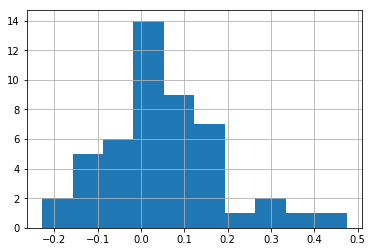

model_train_7


y_pred: [0.5586392]|y_test: [0.82453399]
y_pred: [0.5462782]|y_test: [0.51924743]
y_pred: [0.5372893]|y_test: [0.30989464]
y_pred: [0.5608581]|y_test: [0.72539204]
y_pred: [0.5577078]|y_test: [0.48632996]
y_pred: [0.48589334]|y_test: [0.61381076]
y_pred: [0.5079717]|y_test: [0.50688718]
y_pred: [0.56681174]|y_test: [0.69599409]
y_pred: [0.5952274]|y_test: [0.60533423]
y_pred: [0.5568596]|y_test: [0.46610205]
y_pred: [0.5733794]|y_test: [0.36758053]
y_pred: [0.5257149]|y_test: [0.6261693]
y_pred: [0.52080345]|y_test: [0.41651457]
y_pred: [0.5091544]|y_test: [0.52326547]
y_pred: [0.48729342]|y_test: [0.51913501]
y_pred: [0.45403236]|y_test: [0.58509699]
y_pred: [0.48248872]|y_test: [0.41203001]
y_pred: [0.45466256]|y_test: [0.74217919]
y_pred: [0.44776285]|y_test: [0.58911503]
y_pred: [0.5122284]|y_test: [0.51920347]
y_pred: [0.5100731]|y_test: [0.39582924]
y_pred: [0.47987625]|y_test: [0.45310578]
y_pred: [0.48420373]|y_test: [0.61413117]
y_pred: [0.4833833]|y_test: [0.6

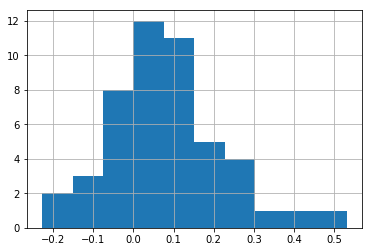

model_train_8


y_pred: [0.52469045]|y_test: [0.82453399]
y_pred: [0.5259057]|y_test: [0.51924743]
y_pred: [0.52679694]|y_test: [0.30989464]
y_pred: [0.5244654]|y_test: [0.72539204]
y_pred: [0.5247739]|y_test: [0.48632996]
y_pred: [0.53191215]|y_test: [0.61381076]
y_pred: [0.5297095]|y_test: [0.50688718]
y_pred: [0.5238671]|y_test: [0.69599409]
y_pred: [0.521062]|y_test: [0.60533423]
y_pred: [0.52484506]|y_test: [0.46610205]
y_pred: [0.52321064]|y_test: [0.36758053]
y_pred: [0.52792984]|y_test: [0.6261693]
y_pred: [0.528407]|y_test: [0.41651457]
y_pred: [0.5295592]|y_test: [0.52326547]
y_pred: [0.5317302]|y_test: [0.51913501]
y_pred: [0.53504366]|y_test: [0.58509699]
y_pred: [0.5322074]|y_test: [0.41203001]
y_pred: [0.53498274]|y_test: [0.74217919]
y_pred: [0.5356704]|y_test: [0.58911503]
y_pred: [0.52925074]|y_test: [0.51920347]
y_pred: [0.5294648]|y_test: [0.39582924]
y_pred: [0.5324675]|y_test: [0.45310578]
y_pred: [0.53203684]|y_test: [0.61413117]
y_pred: [0.5321175]|y_test: [0.684

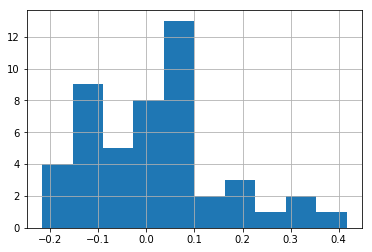

model_train_9


y_pred: [0.54530466]|y_test: [0.82453399]
y_pred: [0.5388318]|y_test: [0.51924743]
y_pred: [0.53511715]|y_test: [0.30989464]
y_pred: [0.5454286]|y_test: [0.72539204]
y_pred: [0.54357594]|y_test: [0.48632996]
y_pred: [0.514999]|y_test: [0.61381076]
y_pred: [0.52324617]|y_test: [0.50688718]
y_pred: [0.54619837]|y_test: [0.69599409]
y_pred: [0.55750453]|y_test: [0.60533423]
y_pred: [0.5406626]|y_test: [0.46610205]
y_pred: [0.54644984]|y_test: [0.36758053]
y_pred: [0.5277982]|y_test: [0.6261693]
y_pred: [0.52333456]|y_test: [0.41651457]
y_pred: [0.5172347]|y_test: [0.52326547]
y_pred: [0.5074598]|y_test: [0.51913501]
y_pred: [0.4927982]|y_test: [0.58509699]
y_pred: [0.5050512]|y_test: [0.41203001]
y_pred: [0.49410307]|y_test: [0.74217919]
y_pred: [0.4905526]|y_test: [0.58911503]
y_pred: [0.5164579]|y_test: [0.51920347]
y_pred: [0.51582754]|y_test: [0.39582924]
y_pred: [0.50386596]|y_test: [0.45310578]
y_pred: [0.50576866]|y_test: [0.61413117]
y_pred: [0.50483054]|y_test: [0

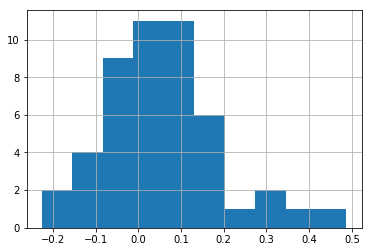

model_train_10


y_pred: [0.5826648]|y_test: [0.82453399]
y_pred: [0.5807064]|y_test: [0.51924743]
y_pred: [0.5795728]|y_test: [0.30989464]
y_pred: [0.5827061]|y_test: [0.72539204]
y_pred: [0.5821479]|y_test: [0.48632996]
y_pred: [0.57335263]|y_test: [0.61381076]
y_pred: [0.57592195]|y_test: [0.50688718]
y_pred: [0.5829472]|y_test: [0.69599409]
y_pred: [0.58634037]|y_test: [0.60533423]
y_pred: [0.5812801]|y_test: [0.46610205]
y_pred: [0.5830347]|y_test: [0.36758053]
y_pred: [0.5773553]|y_test: [0.6261693]
y_pred: [0.57601196]|y_test: [0.41651457]
y_pred: [0.5741507]|y_test: [0.52326547]
y_pred: [0.5711386]|y_test: [0.51913501]
y_pred: [0.56658953]|y_test: [0.58509699]
y_pred: [0.5703981]|y_test: [0.41203001]
y_pred: [0.5669766]|y_test: [0.74217919]
y_pred: [0.56588024]|y_test: [0.58911503]
y_pred: [0.5739387]|y_test: [0.51920347]
y_pred: [0.57374096]|y_test: [0.39582924]
y_pred: [0.5700316]|y_test: [0.45310578]
y_pred: [0.5706206]|y_test: [0.61413117]
y_pred: [0.57033926]|y_test: [0.68

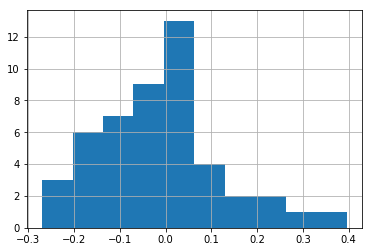

In [0]:
train_index_end= int(len(predictors)*0.8)
test_index_end= len(predictors)


X_train_pre= predictors[0:train_index_end]
X_test_pre= predictors[train_index_end:test_index_end]
y_train_pre= target[0:train_index_end]
y_test_pre= target[train_index_end:test_index_end]

X_norm= MinMaxScaler()
Y_norm= MinMaxScaler()

X_train= X_norm.fit_transform(X_train_pre)
X_test= X_norm.transform(X_test_pre)
y_train= Y_norm.fit_transform(y_train_pre.reshape(-1,1))
y_test= Y_norm.transform(y_test_pre.reshape(-1,1))


for i in range(1,11):
  model_train= locals() ['model_train_' + str(i)]
  y_diff=[]
  y_pred= model_train.predict(X_test)
  
  print('model_train_' + str(i))
  print('\n')
  for j in range(len(y_pred)):
    print('y_pred: ' + str(y_pred[j]) + '|' + 'y_test: ' + str(y_test[j]))
    y_diff.append(float(y_test[j]- y_pred[j]))
    
  print(MSE(y_test,y_pred)**0.5)
  pd.Series(y_diff).hist()
  plt.show()
  

6. Creating Ensemble  2-layer sigmoid-activated ANN (i.e. a combination of all 10 models trained above) and test it with the test data.

y_pred: [0.546714]|y_test: [0.82453399]
y_pred: [0.5427681]|y_test: [0.51924743]
y_pred: [0.5405981]|y_test: [0.30989464]
y_pred: [0.54668677]|y_test: [0.72539204]
y_pred: [0.5455385]|y_test: [0.48632996]
y_pred: [0.5289458]|y_test: [0.61381076]
y_pred: [0.5336786]|y_test: [0.50688718]
y_pred: [0.54692566]|y_test: [0.69599409]
y_pred: [0.5534501]|y_test: [0.60533423]
y_pred: [0.5435225]|y_test: [0.46610205]
y_pred: [0.5467725]|y_test: [0.36758053]
y_pred: [0.5359999]|y_test: [0.6261693]
y_pred: [0.5330845]|y_test: [0.41651457]
y_pred: [0.5293466]|y_test: [0.52326547]
y_pred: [0.5235058]|y_test: [0.51913501]
y_pred: [0.51474416]|y_test: [0.58509699]
y_pred: [0.5220353]|y_test: [0.41203001]
y_pred: [0.51564115]|y_test: [0.74217919]
y_pred: [0.51345813]|y_test: [0.58911503]
y_pred: [0.52864385]|y_test: [0.51920347]
y_pred: [0.5283043]|y_test: [0.39582924]
y_pred: [0.5213239]|y_test: [0.45310578]
y_pred: [0.5224593]|y_test: [0.61413117]
y_pred: [0.52183414]|y_test: [0.68418563]
y_pred: [0.

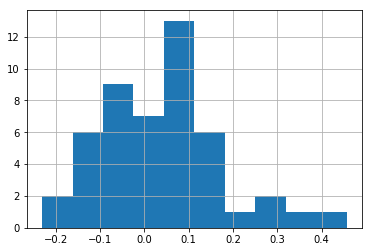

In [0]:
y_pred_1= model_train_1.predict(X_test)
y_pred_2= model_train_2.predict(X_test)
y_pred_3= model_train_3.predict(X_test)
y_pred_4= model_train_4.predict(X_test)
y_pred_5= model_train_5.predict(X_test)
y_pred_6= model_train_6.predict(X_test)
y_pred_7= model_train_7.predict(X_test)
y_pred_8= model_train_8.predict(X_test)
y_pred_9= model_train_9.predict(X_test)
y_pred_10= model_train_10.predict(X_test)

y_pred= (y_pred_1 + y_pred_2 + y_pred_3 + y_pred_4 + y_pred_5 + y_pred_6 + y_pred_7 + y_pred_8 + y_pred_9 + y_pred_10)/10

y_diff=[]
for j in range(len(y_pred)):
  print('y_pred: ' + str(y_pred[j]) + '|' + 'y_test: ' + str(y_test[j]))
  y_diff.append(float(y_test[j]- y_pred[j]))

print(MSE(y_test,y_pred)**0.5)
pd.Series(y_diff).hist()
plt.show()

7. Save all the trained models.

In [0]:
model_train_1.save('EURUSD_model1.h5')
model_train_2.save('EURUSD_model2.h5')
model_train_3.save('EURUSD_model3.h5')
model_train_4.save('EURUSD_model4.h5')
model_train_5.save('EURUSD_model5.h5')
model_train_6.save('EURUSD_model6.h5')
model_train_7.save('EURUSD_model7.h5')
model_train_8.save('EURUSD_model8.h5')
model_train_9.save('EURUSD_model9.h5')
model_train_10.save('EURUSD_model10.h5')


!cp EURUSD_model1.h5 drive/My\ Drive/Trading\ EURUSD\ with\ Deep\ Learning\ Algorithms/
!cp EURUSD_model2.h5 drive/My\ Drive/Trading\ EURUSD\ with\ Deep\ Learning\ Algorithms/
!cp EURUSD_model3.h5 drive/My\ Drive/Trading\ EURUSD\ with\ Deep\ Learning\ Algorithms/
!cp EURUSD_model4.h5 drive/My\ Drive/Trading\ EURUSD\ with\ Deep\ Learning\ Algorithms/
!cp EURUSD_model5.h5 drive/My\ Drive/Trading\ EURUSD\ with\ Deep\ Learning\ Algorithms/
!cp EURUSD_model6.h5 drive/My\ Drive/Trading\ EURUSD\ with\ Deep\ Learning\ Algorithms/
!cp EURUSD_model7.h5 drive/My\ Drive/Trading\ EURUSD\ with\ Deep\ Learning\ Algorithms/
!cp EURUSD_model8.h5 drive/My\ Drive/Trading\ EURUSD\ with\ Deep\ Learning\ Algorithms/
!cp EURUSD_model9.h5 drive/My\ Drive/Trading\ EURUSD\ with\ Deep\ Learning\ Algorithms/
!cp EURUSD_model10.h5 drive/My\ Drive/Trading\ EURUSD\ with\ Deep\ Learning\ Algorithms/

X_train_min_c1= X_train_pre[:,0].min()
X_train_max_c1= X_train_pre[:,0].max()
X_train_min_c2= X_train_pre[:,1].min()
X_train_max_c2= X_train_pre[:,1].max()
y_train_min= y_train_pre.reshape(-1,1).min()
y_train_max= y_train_pre.reshape(-1,1).max()

print('X_train_min_c1 :' + str(X_train_min_c1))
print('X_train_max_c1 :' + str(X_train_max_c1))
print('X_train_min_c2 :' + str(X_train_min_c2))
print('X_train_max_c2 :' + str(X_train_max_c2))
print('y_train_min :' + str(y_train_min))
print('y_train_max :' + str(y_train_max))

scaled_params= pd.DataFrame({'y_train_mean':[mean_return],
                             'y_train_sd':[sd_return],
                             'X_train_min_c1':[X_train_min_c1],
                             'X_train_max_c1':[X_train_max_c1],
                             'X_train_min_c2':[X_train_min_c2],
                             'X_train_max_c2':[X_train_max_c2],
                             'y_train_min':[y_train_min],
                             'y_train_max':[y_train_max]})

scaled_params.to_csv('scaled_params.csv',index=False)
!cp scaled_params.csv drive/My\ Drive/Trading\ EURUSD\ with\ Deep\ Learning\ Algorithms/